In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from xgboost import XGBClassifier

1. import data
2. train-dev-test split
3. Balancing data 
4. Comparing performance on a Clf 

In [3]:
df = pd.read_csv('Vehicle_insurance_encoded.csv')

df.head()

,AccidentArea,Sex,Age,Fault,VehiclePrice,FraudFound_P,RepNumber,Deductible,DriverRating,Days_Policy_Accident,...,VehicleCategory_Sedan,VehicleCategory_Sport,VehicleCategory_Utility,BasePolicy_All Perils,BasePolicy_Collision,BasePolicy_Liability,MaritalStatus_Divorced,MaritalStatus_Married,MaritalStatus_Single,MaritalStatus_Widow
0,0,1,21,0,5.0,0,12,300,1,4.0,...,0,1,0,0,0,1,0,0,1,0
1,0,0,34,0,5.0,0,15,400,4,4.0,...,0,1,0,0,1,0,0,0,1,0
2,0,0,47,0,5.0,0,7,400,3,4.0,...,0,1,0,0,1,0,0,1,0,0
3,1,0,65,1,1.0,0,4,400,2,4.0,...,0,1,0,0,0,1,0,1,0,0
4,0,1,27,1,5.0,0,3,400,1,4.0,...,0,1,0,0,1,0,0,0,1,0


In [4]:
X = df.drop(columns=['FraudFound_P'])

y = df['FraudFound_P']

Spliting and scaling the data before under and over-sampling

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
#Split the Data into Train-Test 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42) 

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

print("Training set size:", X_train.shape)
print("Development set size:", X_val.shape)
print("Testing set size:", X_test.shape)

Training set size: (9252, 61)
Development set size: (3084, 61)
Testing set size: (3084, 61)


In [6]:
from sklearn.model_selection import PredefinedSplit
import numpy as np

# Combine the training and validation data back into a single dataset for GridSearchCV
X_combined = np.vstack((X_train, X_val))
y_combined = np.hstack((y_train, y_val))

# Create the split index (training instances as -1, validation instances as 0)
split_index = [-1] * len(X_train) + [0] * len(X_val)
pds = PredefinedSplit(test_fold=split_index)

XGBoost classification without balancing the data

In [7]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

xgb_model = XGBClassifier()
param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [100, 200, 300],
    'subsample': [0.7, 0.9, 1.0]
}

# Note: No CV parameter is used, as PredefinedSplit is directly applied
grid_search = GridSearchCV(xgb_model, param_grid, cv=pds, scoring='f1_macro', verbose=1, n_jobs=-1)
grid_search.fit(X_combined, y_combined)

Fitting 1 folds for each of 81 candidates, totalling 81 fits


GridSearchCV(cv=PredefinedSplit(test_fold=array([-1, -1, ...,  0,  0])),
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=None, ...),
             n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.1, 0.2],
                         'max_depth': [3, 5, 7],
                         'n_estimators': [100, 200, 300],
                         'subsample': [0.7, 0.9, 1.0]},
             scoring='f1_macro', verbose=1)

In [8]:
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, roc_curve, auc

In [9]:
best_xgb = grid_search.best_estimator_
y_pred = best_xgb.predict(X_test)
y_proba = best_xgb.predict_proba(X_test)[:, 1]  # probabilities

In [10]:
print("Classification Report:")
print(classification_report(y_test, y_pred))


Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.99      0.97      2887
           1       0.51      0.10      0.17       197

    accuracy                           0.94      3084
   macro avg       0.73      0.55      0.57      3084
weighted avg       0.91      0.94      0.92      3084



ROC AUC Score: 0.854096518789814


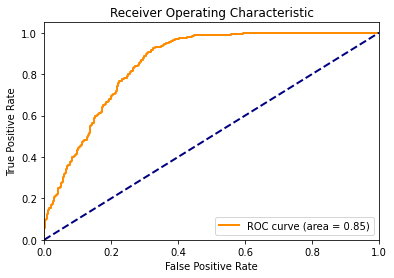

In [11]:
# Calculate ROC AUC
roc_auc = roc_auc_score(y_test, y_proba)
print("ROC AUC Score:", roc_auc)

# Calculate ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_proba)

# Plot ROC Curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

Normalized Confusion Matrix:
[[0.99341877 0.00658123]
 [0.89847716 0.10152284]]


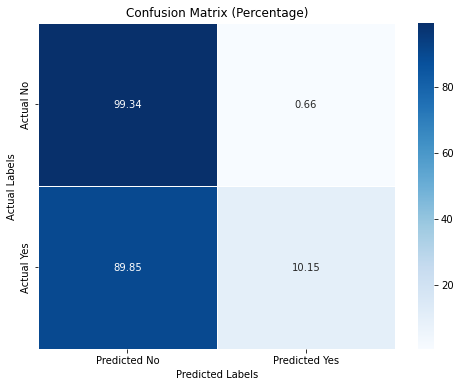

In [12]:
from sklearn.metrics import confusion_matrix
# Confusion Matrix with Percentages
cm_normalized = confusion_matrix(y_test, y_pred, normalize='true')
print("Normalized Confusion Matrix:")
print(cm_normalized)

# Plotting Normalized Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_normalized * 100, annot=True, fmt=".2f", linewidths=.5, cmap="Blues", xticklabels=["Predicted No", "Predicted Yes"], yticklabels=["Actual No", "Actual Yes"])
plt.ylabel('Actual Labels')
plt.xlabel('Predicted Labels')
plt.title('Confusion Matrix (Percentage)')
plt.show()

With random oversampling approach (on the training set)

In [15]:
from imblearn.over_sampling import RandomOverSampler
from collections import Counter

print("Before oversampling: ", Counter(y_train))

oversample = RandomOverSampler(random_state=42)
X_rdmover, y_rdmover = oversample.fit_resample(X_train, y_train)

print("After oversampling: ", Counter(y_rdmover))

Before oversampling:  Counter({0: 8700, 1: 552})
After oversampling:  Counter({0: 8700, 1: 8700})


In [16]:
# Combine the training and validation data back into a single dataset for GridSearchCV
X_combined2 = np.vstack((X_rdmover, X_val))
y_combined2 = np.hstack((y_rdmover, y_val))

# Create the split index (training instances as -1, validation instances as 0)
split_index2 = [-1] * len(X_rdmover) + [0] * len(X_val)
pds2 = PredefinedSplit(test_fold=split_index2)

In [17]:
xgbRO = XGBClassifier()
grid_search_randomOver = GridSearchCV(xgbRO, param_grid, cv=pds2, scoring='f1_macro', verbose=1, n_jobs=-1)
grid_search_randomOver.fit(X_combined2, y_combined2)

Fitting 1 folds for each of 81 candidates, totalling 81 fits


GridSearchCV(cv=PredefinedSplit(test_fold=array([-1, -1, ...,  0,  0])),
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=None, ...),
             n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.1, 0.2],
                         'max_depth': [3, 5, 7],
                         'n_estimators': [100, 200, 300],
                         'subsample': [0.7, 0.9, 1.0]},
             scoring='f1_macro', verbose=1)

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.96      0.96      2887
           1       0.31      0.25      0.28       197

    accuracy                           0.92      3084
   macro avg       0.63      0.61      0.62      3084
weighted avg       0.91      0.92      0.91      3084

ROC AUC Score: 0.8579787916777292


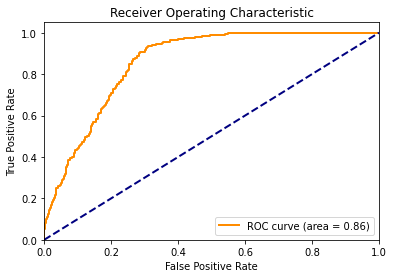

In [18]:
best_xgbRO = grid_search_randomOver.best_estimator_
y_pred2 = best_xgbRO.predict(X_test)
y_proba2 = best_xgbRO.predict_proba(X_test)[:, 1]  # probabilities

print("Classification Report:")
print(classification_report(y_test, y_pred2))

# Calculate ROC AUC
roc_auc2 = roc_auc_score(y_test, y_proba2)
print("ROC AUC Score:", roc_auc2)

# Calculate ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_proba2)

# Plot ROC Curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc2)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()



Normalized Confusion Matrix:
[[0.96259092 0.03740908]
 [0.75126904 0.24873096]]


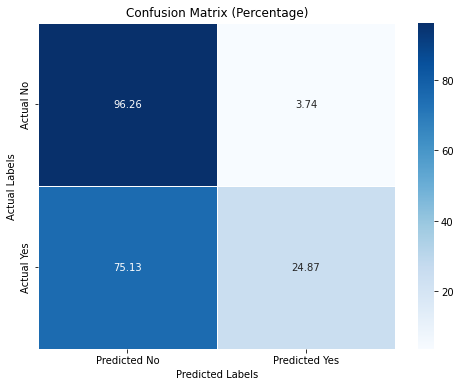

In [19]:
from sklearn.metrics import confusion_matrix
# Confusion Matrix with Percentages
cm_normalized = confusion_matrix(y_test, y_pred2, normalize='true')
print("Normalized Confusion Matrix:")
print(cm_normalized)

# Plotting Normalized Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_normalized * 100, annot=True, fmt=".2f", linewidths=.5, cmap="Blues", xticklabels=["Predicted No", "Predicted Yes"], yticklabels=["Actual No", "Actual Yes"])
plt.ylabel('Actual Labels')
plt.xlabel('Predicted Labels')
plt.title('Confusion Matrix (Percentage)')
plt.show()

With SMOTE

In [20]:
from imblearn.over_sampling import SMOTE
from collections import Counter

In [21]:
# Summarize class distribution
print("Before oversampling: ", Counter(y_train))

# Define SMOTE model
smote = SMOTE(random_state=42)

# Fit and apply the transform
X_smote, y_smote = smote.fit_resample(X_train, y_train)

# Summarize new class distribution
print("After oversampling with SMOTE: ", Counter(y_smote))

Before oversampling:  Counter({0: 8700, 1: 552})
After oversampling with SMOTE:  Counter({0: 8700, 1: 8700})


In [22]:
# Combine the training and validation data back into a single dataset for GridSearchCV
X_combined3 = np.vstack((X_smote, X_val))
y_combined3 = np.hstack((y_smote, y_val))

# Create the split index (training instances as -1, validation instances as 0)
split_index3 = [-1] * len(X_smote) + [0] * len(X_val)
pds3 = PredefinedSplit(test_fold=split_index3)

In [23]:
xgbSMOTE = XGBClassifier()
grid_search_smote = GridSearchCV(xgbSMOTE, param_grid, cv=pds3, scoring='f1_macro', verbose=1, n_jobs=-1)
grid_search_smote.fit(X_combined3, y_combined3)

Fitting 1 folds for each of 81 candidates, totalling 81 fits


GridSearchCV(cv=PredefinedSplit(test_fold=array([-1, -1, ...,  0,  0])),
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=None, ...),
             n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.1, 0.2],
                         'max_depth': [3, 5, 7],
                         'n_estimators': [100, 200, 300],
                         'subsample': [0.7, 0.9, 1.0]},
             scoring='f1_macro', verbose=1)

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.96      0.96      2887
           1       0.31      0.25      0.28       197

    accuracy                           0.92      3084
   macro avg       0.63      0.61      0.62      3084
weighted avg       0.91      0.92      0.91      3084

ROC AUC Score: 0.8579787916777292


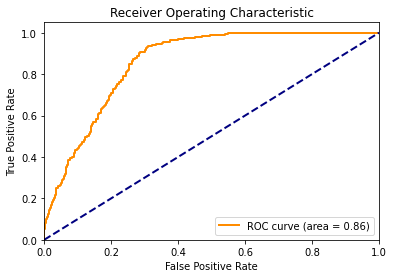

In [24]:
best_xgbSMOTE = grid_search_randomOver.best_estimator_
y_pred3 = best_xgbSMOTE.predict(X_test)
y_proba3 = best_xgbSMOTE.predict_proba(X_test)[:, 1]  # probabilities

print("Classification Report:")
print(classification_report(y_test, y_pred3))

# Calculate ROC AUC
roc_auc3 = roc_auc_score(y_test, y_proba3)
print("ROC AUC Score:", roc_auc3)

# Calculate ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_proba3)

# Plot ROC Curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc3)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

Normalized Confusion Matrix:
[[0.96259092 0.03740908]
 [0.75126904 0.24873096]]


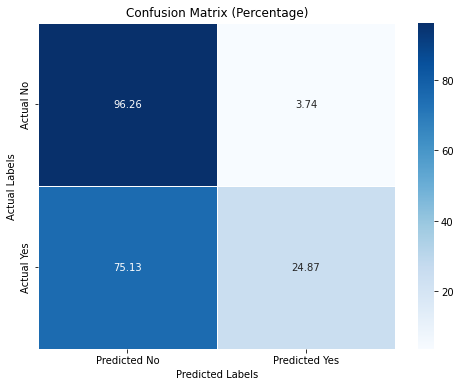

In [25]:
from sklearn.metrics import confusion_matrix
# Confusion Matrix with Percentages
cm_normalized = confusion_matrix(y_test, y_pred3, normalize='true')
print("Normalized Confusion Matrix:")
print(cm_normalized)

# Plotting Normalized Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_normalized * 100, annot=True, fmt=".2f", linewidths=.5, cmap="Blues", xticklabels=["Predicted No", "Predicted Yes"], yticklabels=["Actual No", "Actual Yes"])
plt.ylabel('Actual Labels')
plt.xlabel('Predicted Labels')
plt.title('Confusion Matrix (Percentage)')
plt.show()

ADASYN

In [26]:
from imblearn.over_sampling import ADASYN

# Summarize class distribution
print("Before oversampling: ", Counter(y_train))

# Define ADASYN model
adasyn = ADASYN(random_state=42)

# Fit and apply the transform
X_adasyn, y_adasyn = adasyn.fit_resample(X_train, y_train)

# Summarize new class distribution
print("After oversampling with ADASYN: ", Counter(y_adasyn))

Before oversampling:  Counter({0: 8700, 1: 552})
After oversampling with ADASYN:  Counter({1: 8716, 0: 8700})


In [27]:
# Combine the training and validation data back into a single dataset for GridSearchCV
X_combined4 = np.vstack((X_adasyn, X_val))
y_combined4 = np.hstack((y_adasyn, y_val))

# Create the split index (training instances as -1, validation instances as 0)
split_index4 = [-1] * len(X_adasyn) + [0] * len(X_val)
pds4 = PredefinedSplit(test_fold=split_index4)

In [28]:
xgbADASYN = XGBClassifier()
grid_search_adasyn = GridSearchCV(xgbADASYN, param_grid, cv=pds4, scoring='f1_macro', verbose=1, n_jobs=-1)
grid_search_adasyn.fit(X_combined4, y_combined4)

Fitting 1 folds for each of 81 candidates, totalling 81 fits


GridSearchCV(cv=PredefinedSplit(test_fold=array([-1, -1, ...,  0,  0])),
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=None, ...),
             n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.1, 0.2],
                         'max_depth': [3, 5, 7],
                         'n_estimators': [100, 200, 300],
                         'subsample': [0.7, 0.9, 1.0]},
             scoring='f1_macro', verbose=1)

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.96      0.96      2887
           1       0.31      0.25      0.28       197

    accuracy                           0.92      3084
   macro avg       0.63      0.61      0.62      3084
weighted avg       0.91      0.92      0.91      3084

ROC AUC Score: 0.8579787916777292


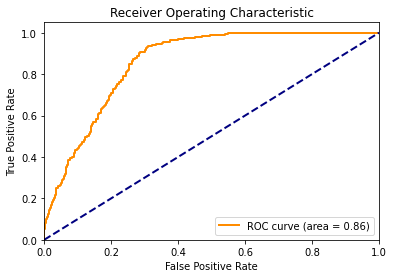

In [29]:
best_xgbADASYN = grid_search_randomOver.best_estimator_
y_pred4 = best_xgbADASYN.predict(X_test)
y_proba4 = best_xgbADASYN.predict_proba(X_test)[:, 1]  # probabilities

print("Classification Report:")
print(classification_report(y_test, y_pred4))

# Calculate ROC AUC
roc_auc4 = roc_auc_score(y_test, y_proba4)
print("ROC AUC Score:", roc_auc4)

# Calculate ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_proba4)

# Plot ROC Curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc4)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

Normalized Confusion Matrix:
[[0.96259092 0.03740908]
 [0.75126904 0.24873096]]


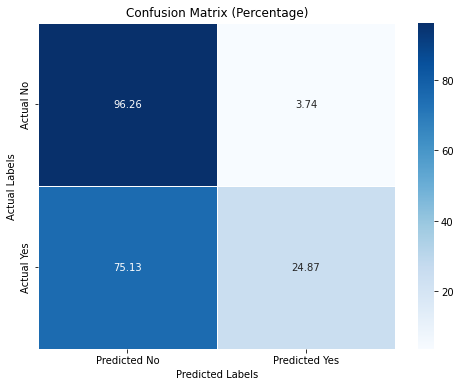

In [30]:
from sklearn.metrics import confusion_matrix
# Confusion Matrix with Percentages
cm_normalized = confusion_matrix(y_test, y_pred4, normalize='true')
print("Normalized Confusion Matrix:")
print(cm_normalized)

# Plotting Normalized Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_normalized * 100, annot=True, fmt=".2f", linewidths=.5, cmap="Blues", xticklabels=["Predicted No", "Predicted Yes"], yticklabels=["Actual No", "Actual Yes"])
plt.ylabel('Actual Labels')
plt.xlabel('Predicted Labels')
plt.title('Confusion Matrix (Percentage)')
plt.show()

Cost-sentsitive XGBoost

In [31]:
# SMOTE + cost sensitive 
xgbCS = XGBClassifier(scale_pos_weight=167)

grid_search_CS = GridSearchCV(xgbCS, param_grid, cv=pds, scoring='f1_macro', verbose=1, n_jobs=-1)
grid_search_CS.fit(X_combined, y_combined)

Fitting 1 folds for each of 81 candidates, totalling 81 fits


GridSearchCV(cv=PredefinedSplit(test_fold=array([-1, -1, ...,  0,  0])),
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=None, ...),
             n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.1, 0.2],
                         'max_depth': [3, 5, 7],
                         'n_estimators': [100, 200, 300],
                         'subsample': [0.7, 0.9, 1.0]},
             scoring='f1_macro', verbose=1)

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.86      0.91      2887
           1       0.21      0.57      0.31       197

    accuracy                           0.84      3084
   macro avg       0.59      0.71      0.61      3084
weighted avg       0.92      0.84      0.87      3084

ROC AUC Score: 0.8457851492512383


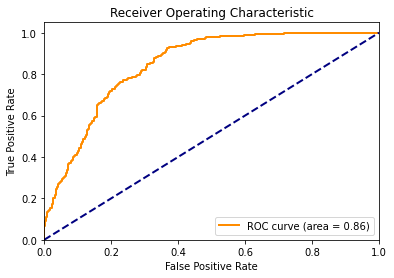

In [32]:
best_xgbCS = grid_search_CS.best_estimator_
y_pred5 = best_xgbCS.predict(X_test)
y_proba5 = best_xgbCS.predict_proba(X_test)[:, 1]  # probabilities

print("Classification Report:")
print(classification_report(y_test, y_pred5))

# Calculate ROC AUC
roc_auc5 = roc_auc_score(y_test, y_proba5)
print("ROC AUC Score:", roc_auc5)

# Calculate ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_proba5)

# Plot ROC Curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc4)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

Normalized Confusion Matrix:
[[0.85729131 0.14270869]
 [0.43147208 0.56852792]]


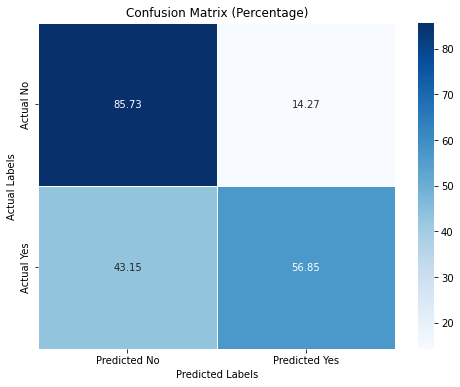

In [33]:
from sklearn.metrics import confusion_matrix
# Confusion Matrix with Percentages
cm_normalized = confusion_matrix(y_test, y_pred5, normalize='true')
print("Normalized Confusion Matrix:")
print(cm_normalized)

# Plotting Normalized Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_normalized * 100, annot=True, fmt=".2f", linewidths=.5, cmap="Blues", xticklabels=["Predicted No", "Predicted Yes"], yticklabels=["Actual No", "Actual Yes"])
plt.ylabel('Actual Labels')
plt.xlabel('Predicted Labels')
plt.title('Confusion Matrix (Percentage)')
plt.show()